## Questions to be addressed

------------------

During the meetings the following questions have arisen:

1. Hamiltonian sign: Do logarithmic corrections also appear when the global sign in the Hamiltonian is positive? They are not the same Hamiltonian in odd length chains because the usual mapping $\sigma_n^a \mapsto -\sigma_n^a$ is no longer a symmetry of the Hamiltonian.

2. Discrepancies between the $\alpha$ predicted by Germán's iMPS and our max_amplitude/max_entropy.

3. Do logarithmic corrections also appear in Shannon entropy?

Additional things:

- Ising model at critical point exhibits the same behavior?

------------------------------------

In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.special import gamma
import scipy.sparse as sparse
import numpy as np
import amptools
import os

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{physics} \usepackage{mathtools}")
plt.rc("font", family="serif", size=36, weight="bold")

### 1. Hamiltonian sign

$$H = (-1)^{s} \sum_n (\sigma_{n}^x \sigma_{n+1}^x + \sigma_{n}^y \sigma_{n+1}^y + \Delta \sigma_{n}^z \sigma_{n+1}^z)$$

#### 1.1 Insights on the ground state

**Legend:**

|0> = $\ket{\uparrow}$
    
|1> = $\ket{\downarrow}$

##### 1.1.1 Positive global sign $(s = 0)$

When the global sign is positive, the non-critical point is $\Delta = -1$. Notice how in this case, even though frustration appears for every $\Delta$, States with $S = 1/2$ ($S = -1/2$) total spin are energetically favorable for $\Delta > 0$ ($\Delta < 0$)

In [2]:
N = 9
global_neg = False
delta_range = [-1, 1]
resolution = 21

delta_arr = np.linspace(*delta_range, resolution)
max_amp, max_amps_inds = amptools.get_xxz_numerical_max_amps(N, delta_arr, global_neg, return_max_amp_ind=True)
for delta, ind in zip(delta_arr, max_amps_inds):
    state_string = amptools.conf_index_to_str(ind, N)
    print(f"Δ = {delta:.02f} / Ground state: {state_string}")

Δ = -1.00 / Ground state: |000001111>
Δ = -0.90 / Ground state: |001010101>
Δ = -0.80 / Ground state: |001010101>
Δ = -0.70 / Ground state: |001010101>
Δ = -0.60 / Ground state: |001010101>
Δ = -0.50 / Ground state: |001010101>
Δ = -0.40 / Ground state: |001010101>
Δ = -0.30 / Ground state: |001010101>
Δ = -0.20 / Ground state: |001010101>
Δ = -0.10 / Ground state: |001010101>
Δ = 0.00 / Ground state: |001010101>
Δ = 0.10 / Ground state: |001010101>
Δ = 0.20 / Ground state: |001010101>
Δ = 0.30 / Ground state: |001010101>
Δ = 0.40 / Ground state: |001010101>
Δ = 0.50 / Ground state: |001010101>
Δ = 0.60 / Ground state: |001010101>
Δ = 0.70 / Ground state: |001010101>
Δ = 0.80 / Ground state: |001010101>
Δ = 0.90 / Ground state: |001010101>
Δ = 1.00 / Ground state: |001010101>


##### 1.1.2 Negative global sign $(s = 1)$

When the global sign is negative, the non-critical point is $\Delta = 1$ (Consistent with 1.1.1). States with $S = 1/2$ are energy favorable $\forall \Delta$

In [3]:
N = 9
global_neg = False
delta_range = [-1, 1]
resolution = 21

delta_arr = np.linspace(*delta_range, resolution)
max_amp, max_amps_inds = amptools.get_xxz_numerical_max_amps(N, delta_arr, global_neg, return_max_amp_ind=True)
for delta, ind in zip(delta_arr, max_amps_inds):
    state_string = amptools.conf_index_to_str(ind, N)
    print(f"Δ = {delta:.02f} / Ground state: {state_string}")

Δ = -1.00 / Ground state: |000001111>
Δ = -0.90 / Ground state: |001010101>
Δ = -0.80 / Ground state: |001010101>
Δ = -0.70 / Ground state: |001010101>
Δ = -0.60 / Ground state: |001010101>
Δ = -0.50 / Ground state: |001010101>
Δ = -0.40 / Ground state: |001010101>
Δ = -0.30 / Ground state: |001010101>
Δ = -0.20 / Ground state: |001010101>
Δ = -0.10 / Ground state: |001010101>
Δ = 0.00 / Ground state: |001010101>
Δ = 0.10 / Ground state: |001010101>
Δ = 0.20 / Ground state: |001010101>
Δ = 0.30 / Ground state: |001010101>
Δ = 0.40 / Ground state: |001010101>
Δ = 0.50 / Ground state: |001010101>
Δ = 0.60 / Ground state: |001010101>
Δ = 0.70 / Ground state: |001010101>
Δ = 0.80 / Ground state: |001010101>
Δ = 0.90 / Ground state: |001010101>
Δ = 1.00 / Ground state: |001010101>


**Conclusions:** 
1. All states are Nèel in the critical region -> Always antiferromagnetic.
2. The fact that these Hamiltonians are not equivalent really shows up in the ground state. Does this matter for the behavior of the entanglement entropy?. Another observation is that in the non-critical point the model is sort of *antiferromagnetic* at the non-critical point, but the favoured spin sector is changed

#### 1.2 Comparison with analytical results

Sunny got exact results for the **AMPLITUDE** of the ground state of the model at particular points.

##### 1.2.1 $s = 1, \Delta = -1/2$

Num: N = 21 / Δ = -0.50

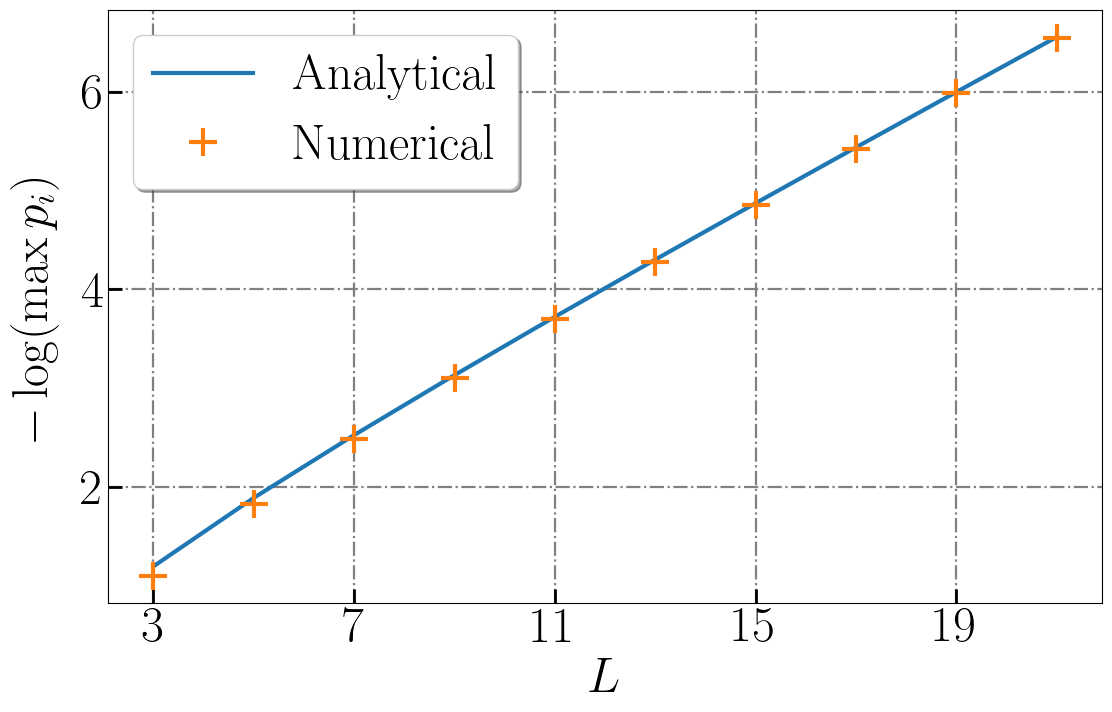

In [4]:
N_odd_range = [3, 23]
global_neg = True
delta = -1/2
print_mode = True
stirlin_approx = True # When set to False, the overlap is exceptional

N_arr = np.arange(*N_odd_range, 2)
max_amps_arr, Egs_arr, max_amp_inds_arr = amptools.get_xxz_numerical_max_amps(N_arr, delta, global_neg, return_energy=True, return_max_amp_ind=True, print_mode=print_mode)

def analytical_log_max_amp(N, stirling=True):
    if stirling:
        return (N-1)*np.log(3*np.sqrt(3)/4) + 2*np.log(np.sqrt(np.pi)/gamma(2/3)) + np.log(N/2)/3 # Stirling formula approximation
    else:
        return (N-1)*np.log(3*np.sqrt(3)/4) + 2*np.log(np.sqrt(np.pi)/gamma(2/3)) + 2*np.log(gamma(N/2 + 1/6)/gamma(N/2)) # Exact expression
    
fig, ax = plt.subplots(1, 1, figsize=[12, 8])

plt.plot(N_arr, analytical_log_max_amp(N_arr), linewidth=3, label="Analytical")
plt.plot(N_arr, -np.log(max_amps_arr), "+", markersize=20, markeredgewidth=3, label="Numerical")

plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tick_params(width=2, length=10, direction="in")
plt.xlabel("$L$")
plt.ylabel(r"$-\log (\max p_i)$", labelpad=15)
plt.xticks(np.arange(N_arr[0], N_arr[-1] + 1, 4))
plt.tight_layout()
plt.legend(shadow=True)

##### 1.2.2 $s = 1, \Delta = 0$

Num: N = 21 / Δ = 0.00
An: N = 21

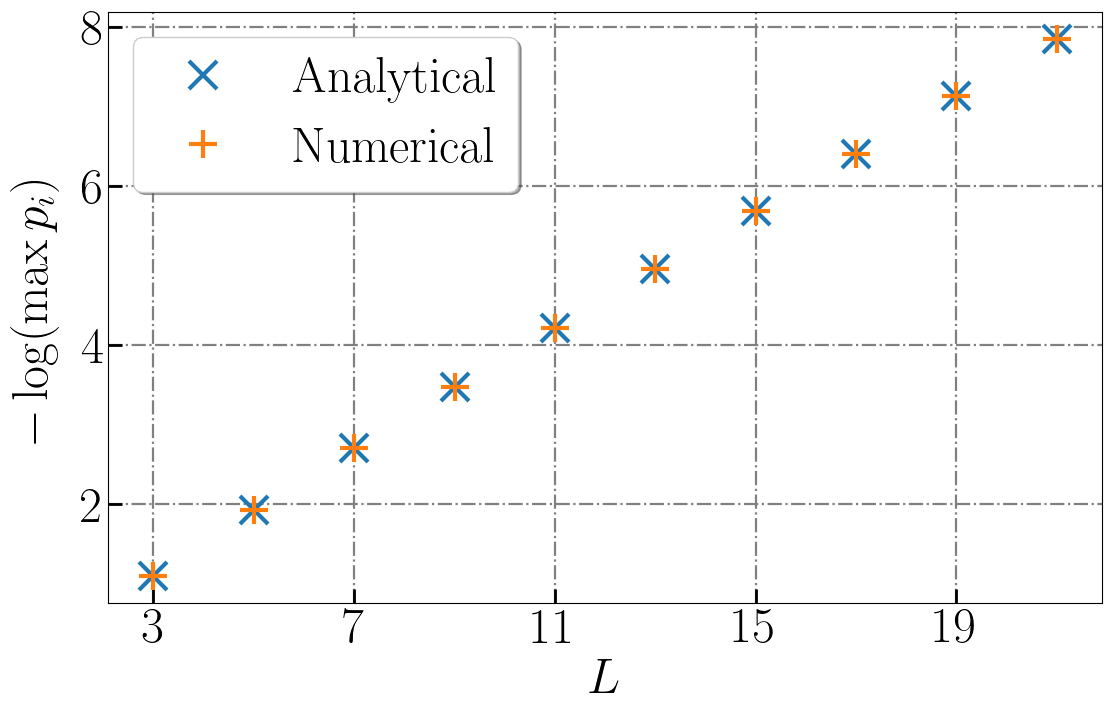

In [5]:
N_odd_range = [3, 23]
global_neg = True
delta = 0
print_mode = True

N_arr = np.arange(*N_odd_range, 2)
max_amps_num_arr, Egs_arr = amptools.get_xxz_numerical_max_amps(N_arr, delta, global_neg, return_energy=True, print_mode=print_mode)
if print_mode: print("")
max_amps_an_arr = amptools.get_analytical_xx_max_amps(N_arr, print_mode=True)

fig, ax = plt.subplots(1, 1, figsize=[12, 8])

plt.plot(N_arr, -np.log(max_amps_an_arr), "x", markersize=20, markeredgewidth=3, label="Analytical")
plt.plot(N_arr, -np.log(max_amps_num_arr), "+", markersize=20, markeredgewidth=3, label="Numerical")

plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tick_params(width=2, length=10, direction="in")
plt.xlabel("$L$")
plt.ylabel(r"$-\log (\max p_i)$", labelpad=15)
plt.xticks(np.arange(N_arr[0], N_arr[-1] + 1, 4))
plt.tight_layout()
plt.legend(shadow=True)

#### 1.3 Entropy regressions

$$S \sim aL + b \log L + c$$

**Legend:**

$S_R^{(\infty)} = -\log(\max p_i)$ (Min entropy/Rényi entopy of infinite order)

$S_{\mathrm{Sh}} = -\sum_i p_i \log(p_i)$ (Shannon entropy)

In [6]:
def to_fit_renyi_inf(N, a, b, c):
    return a*N + b*np.log(N) + c

def to_fit_shannon(N, a, b, c):
    return a*N + b*np.log(N) + c

##### 1.3.1 Positive global sign ($s = 0$)

1.3.1.1 Fit on the max extropy
- Single $\Delta$ value

Num: N = 21 / Δ = 0.00


∞-Rènyi entropy fit result

Fit function: a L + b log L + c
a = 0.3462528313423084 ± 3.499751049260022e-05
b = 0.2568832167790614 ± 0.0004983943753429264
c = -0.2089756969930725 ± 0.000812340542994709


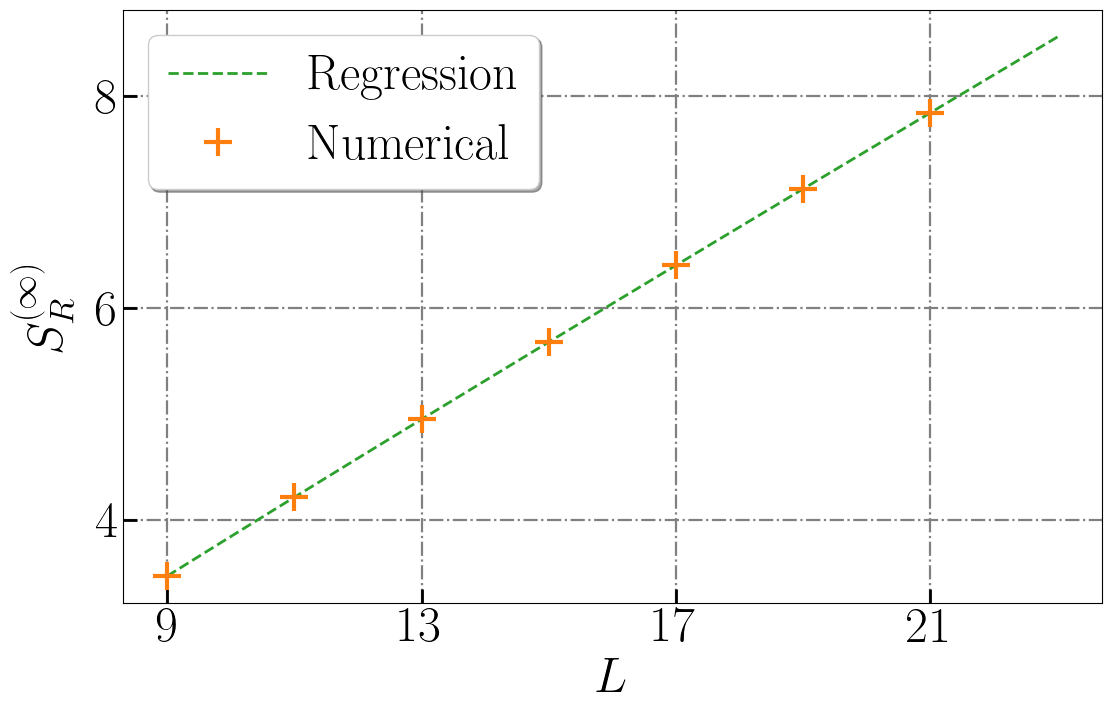

In [7]:
N_odd_range = [9, 23]
global_neg = False
delta = 0
print_mode = True
initials = [0.1, 0.1, 0.1]

N_arr = np.arange(*N_odd_range, 2)
max_amps_num_arr = amptools.get_xxz_numerical_max_amps(N_arr, delta, global_neg, print_mode=print_mode)

regression = curve_fit(to_fit_renyi_inf, N_arr, -np.log(max_amps_num_arr), p0=initials)
popt = regression[0]
errors = np.sqrt(np.diag(regression[1]))

print("\n∞-Rènyi entropy fit result\n")
print("Fit function: a L + b log L + c")
print(f"a = {popt[0]} ± {errors[0]}")
print(f"b = {popt[1]} ± {errors[1]}")
print(f"c = {popt[2]} ± {errors[2]}")

fig, ax = plt.subplots(1, 1, figsize=[12, 8])

smooth_N_arr = np.linspace(N_odd_range[0], N_odd_range[1], 1000)

plt.plot(smooth_N_arr, to_fit_renyi_inf(smooth_N_arr, *popt), "--", color="tab:green", linewidth=2, label="Regression")
plt.plot(N_arr, -np.log(max_amps_num_arr), "+", color="tab:orange", markersize=20, markeredgewidth=3, label="Numerical")

plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tick_params(width=2, length=10, direction="in")
plt.xlabel("$L$")
plt.ylabel(r"$S_{R}^{(\infty)}$", labelpad=15)
plt.xticks(np.arange(N_arr[0], N_arr[-1] + 1, 4))
plt.legend(shadow=True)
plt.tight_layout()

- Multiple $\Delta$ values

In [8]:
N_odd_range = [9, 21]
global_neg = False
delta_arr = np.linspace(-1, 1, 21)
print_mode = True
initials = [0.1, 0.1, 0.1]

N_arr = np.arange(*N_odd_range, 2)
params_arr = []
params_err_arr = []
max_amps_arr = amptools.get_xxz_numerical_max_amps(N_arr, delta_arr, global_neg, print_mode=print_mode)
for i, delta in enumerate(delta_arr):
    regression = curve_fit(to_fit_renyi_inf, N_arr, -np.log(max_amps_arr[:, i]), p0=initials)
    popt = regression[0]
    errors = np.sqrt(np.diag(regression[1]))
    params_arr.append(popt)
    params_err_arr.append(errors)

Num: N = 15 / Δ = -0.80

Num: N = 19 / Δ = 1.000

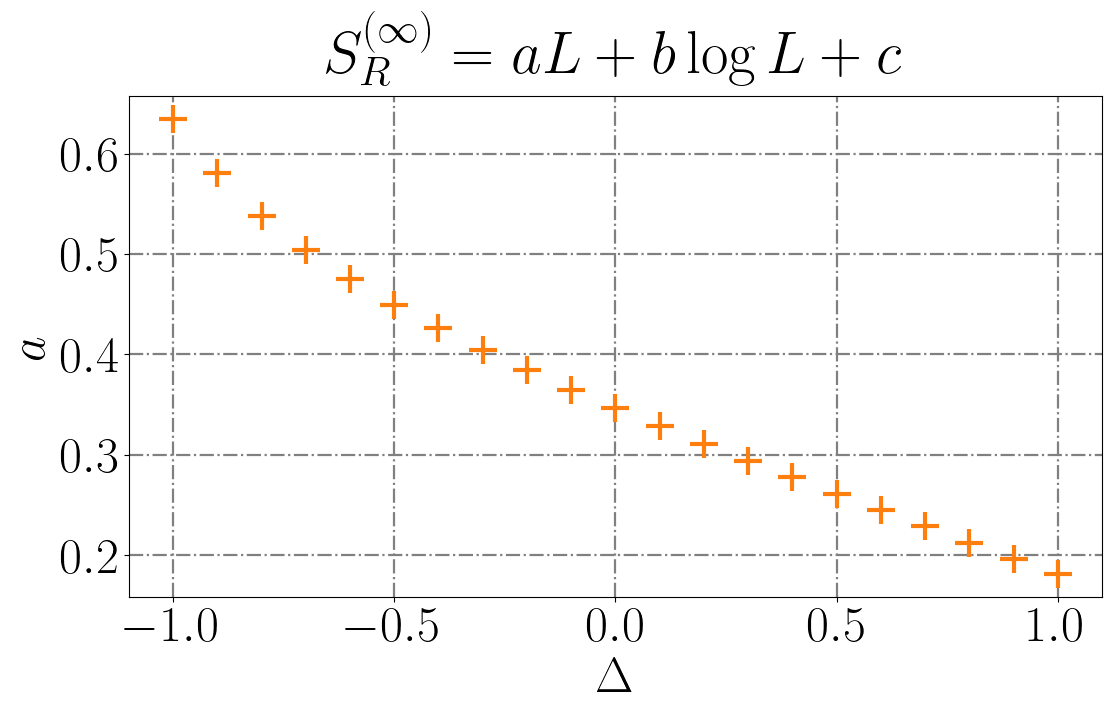

In [9]:
fig, ax = plt.subplots(1, 1, figsize=[12, 8])
plt.plot(delta_arr, [popt[0] for popt in params_arr], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$a$")
plt.title(r"$S_{R}^{(\infty)} = a L + b \log L + c$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
# plt.savefig(f"alpha_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

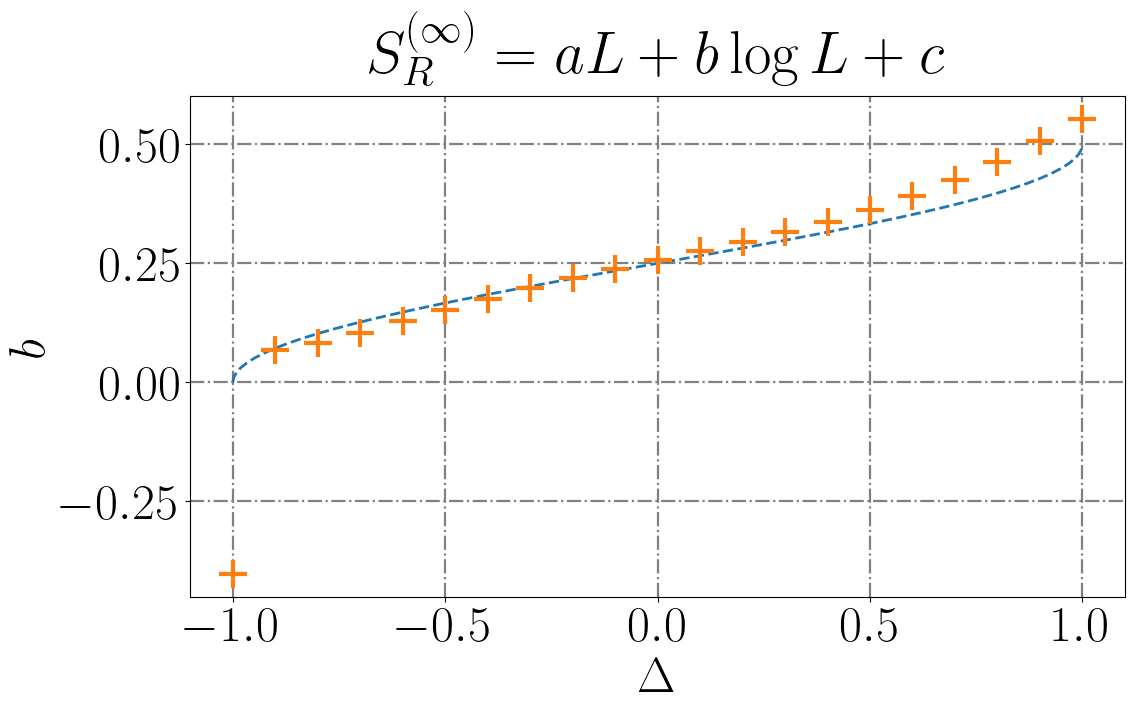

In [10]:
fig, ax = plt.subplots(1, 1, figsize=[12, 8])
beta = np.linspace(0, 0.5)
delta = -np.cos(2*np.pi*beta)
plt.plot(delta, beta, "--", linewidth=2, label=r"$\Delta = -\cos(2\pi \alpha)$")
plt.plot(delta_arr, [popt[1] for popt in params_arr], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$b$")
plt.title(r"$S_{R}^{(\infty)} = a L + b \log L + c$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
# plt.savefig(f"beta_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

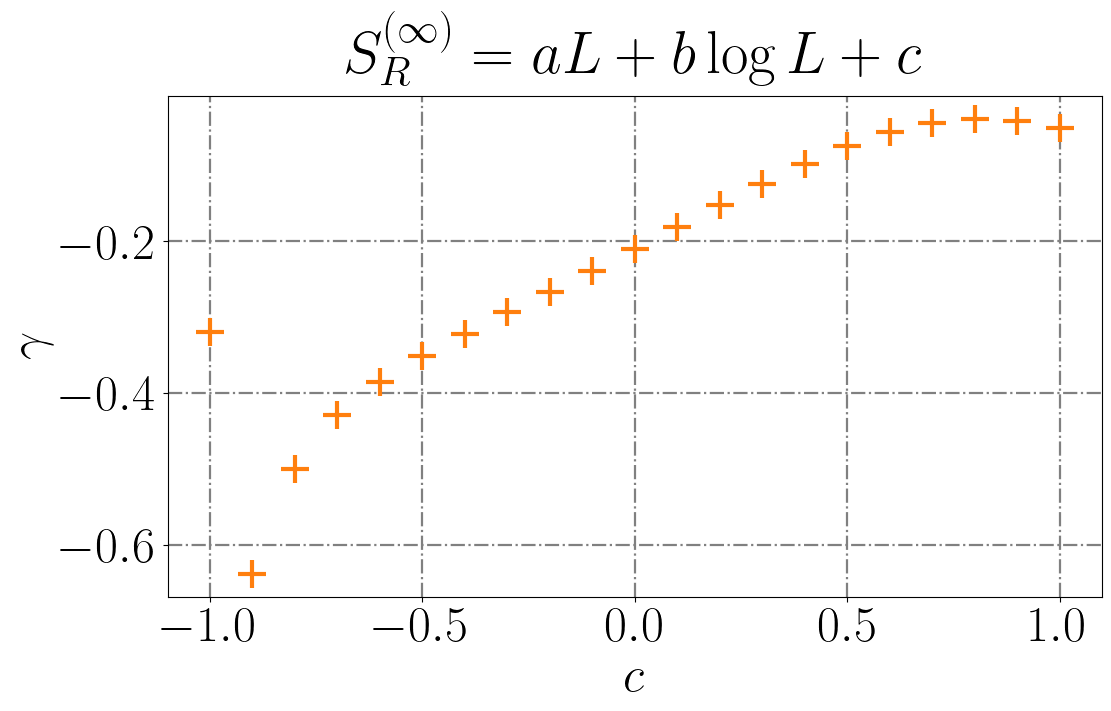

In [11]:
fig, ax = plt.subplots(1, 1, figsize=[12, 8])
plt.plot(delta_arr, [popt[2] for popt in params_arr], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$c$")
plt.ylabel(r"$\gamma$")
plt.title(r"$S_{R}^{(\infty)} = a L + b \log L + c$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
# plt.savefig(f"gamma_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

1.3.1.2 Fit on the Shannon entropy
- Single $\Delta$ value

Num: N = 19
Shannon entropy fit result

Fit function: a L + b log L + c
a = 0.5943758771102925 ± 3.397577470817571e-05
b = -0.002456885796498991 ± 0.0004559755642135182
c = -0.6801322307397735 ± 0.000718142501895394


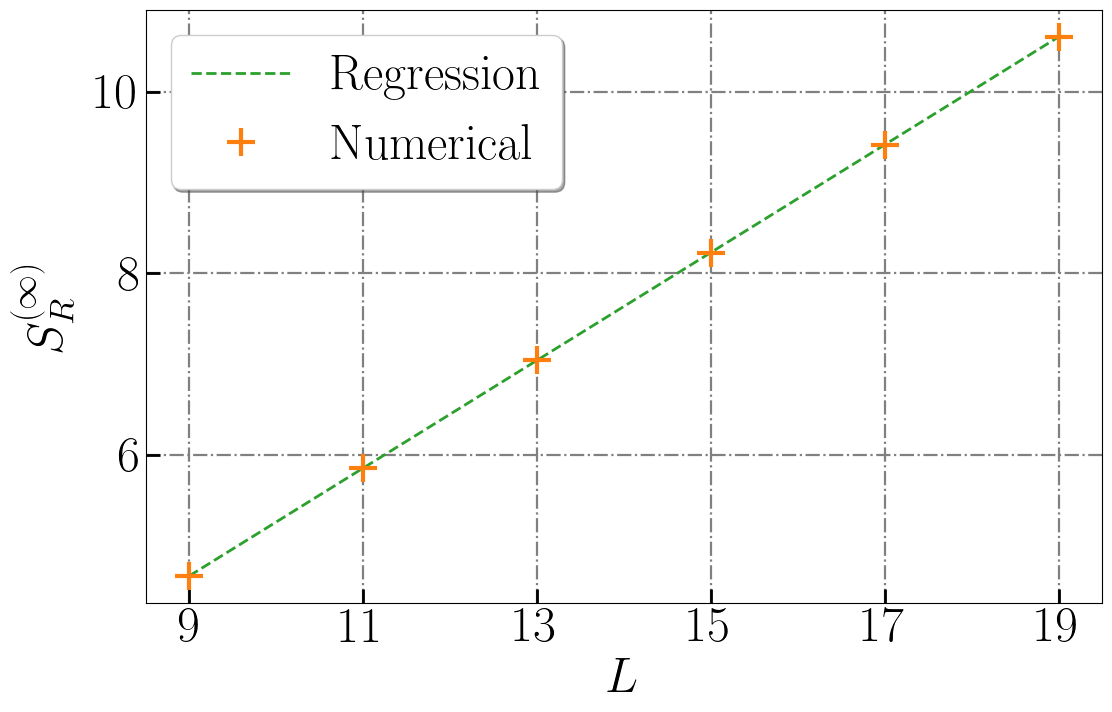

In [12]:
N_odd_range = [9, 21]
global_neg = False
delta = -1/2
print_mode = True
initials = [0.1, 0.1, 0.1]

N_arr = np.arange(*N_odd_range, 2)
shannon_arr = amptools.get_xxz_numerical_shannon(N_arr, delta, global_neg, print_mode=print_mode)

regression = curve_fit(to_fit_shannon, N_arr, shannon_arr, p0=initials)
popt = regression[0]
errors = np.sqrt(np.diag(regression[1]))

print("\nShannon entropy fit result\n")
print("Fit function: a L + b log L + c")
print(f"a = {popt[0]} ± {errors[0]}")
print(f"b = {popt[1]} ± {errors[1]}")
print(f"c = {popt[2]} ± {errors[2]}")

fig, ax = plt.subplots(1, 1, figsize=[12, 8])

smooth_N_arr = np.linspace(N_odd_range[0], N_odd_range[1] - 2, 1000)

plt.plot(smooth_N_arr, to_fit_shannon(smooth_N_arr, *popt), "--", color="tab:green", linewidth=2, label="Regression")
plt.plot(N_arr, shannon_arr, "+", color="tab:orange", markersize=20, markeredgewidth=3, label="Numerical")

plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tick_params(width=2, length=10, direction="in")
plt.xlabel("$L$")
plt.ylabel(r"$S_{R}^{(\infty)}$", labelpad=15)
plt.xticks(np.arange(N_arr[0], N_arr[-1]+2, 2))
plt.legend(shadow=True)
plt.tight_layout()

- Multiple $\Delta$ values

In [13]:
N_odd_range = [9, 21]
global_neg = False
delta_arr = np.linspace(-1, 1, 21)
print_mode = True
initials = [0.1, 0.1, 0.1]

N_arr = np.arange(*N_odd_range, 2)
params_arr = []
params_err_arr = []
shannon_arr = amptools.get_xxz_numerical_shannon(N_arr, delta_arr, global_neg, print_mode=print_mode)
for i, delta in enumerate(delta_arr):
    regression = curve_fit(to_fit_shannon, N_arr, shannon_arr[:, i], p0=initials)
    popt = regression[0]
    errors = np.sqrt(np.diag(regression[1]))
    params_arr.append(popt)
    params_err_arr.append(errors)

Num: N = 19

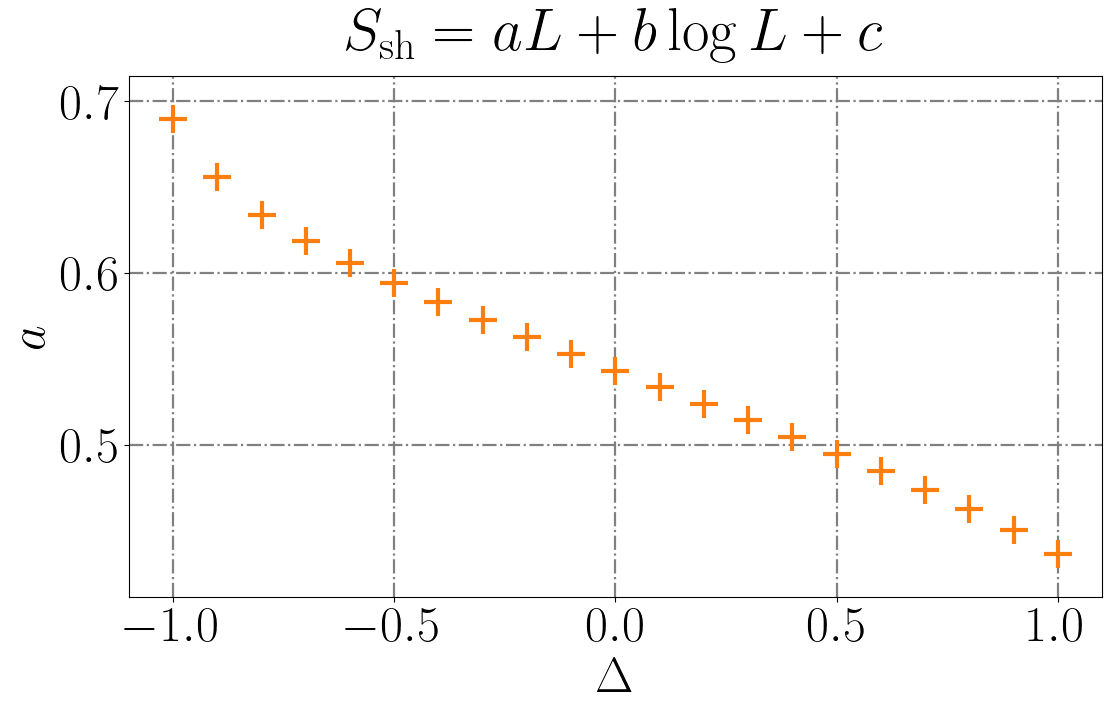

In [14]:
remove_last = 0

sl = slice(None, -remove_last if remove_last > 0 else None, None)
fig, ax = plt.subplots(1, 1, figsize=[12, 8])
yplot = np.array([popt[0] for popt in params_arr[sl]])
plt.plot(delta_arr[sl], yplot[sl], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$a$")
plt.xticks(np.linspace(*delta_range, 5))
plt.xlim(-0.05*(delta_range[1] - delta_range[0]) + delta_range[0], delta_range[1] + 0.05*(delta_range[1] - delta_range[0]))
plt.ylim(np.min(yplot) - 0.10*(np.max(yplot) - np.min(yplot)), np.max(yplot) + 0.10*(np.max(yplot) - np.min(yplot)))
plt.title(r"$S_{\mathrm{sh}} = a L + b \log L + c$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
# plt.savefig(f"alpha_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

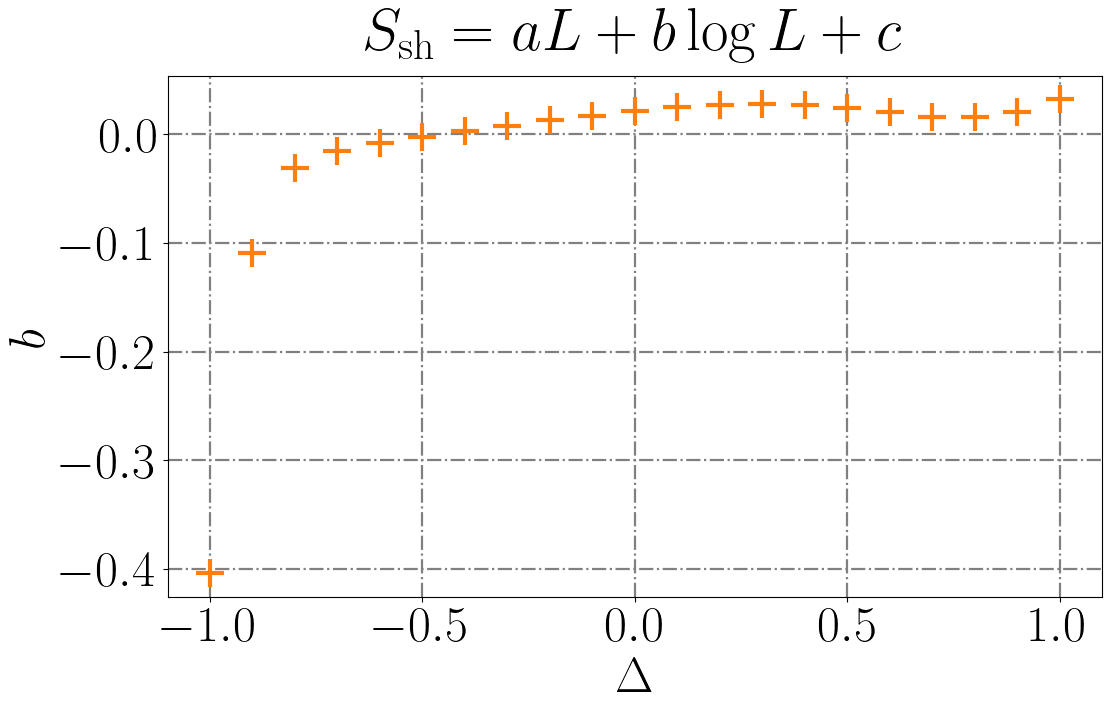

In [15]:
remove_last = 0

sl = slice(None, -remove_last if remove_last > 0 else None, None)
fig, ax = plt.subplots(1, 1, figsize=[12, 8])
plt.plot(delta_arr[sl], [popt[1] for popt in params_arr[sl]], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$b$")
plt.title(r"$S_{\mathrm{sh}} = a L + b \log L + c$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
# plt.savefig(f"beta_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

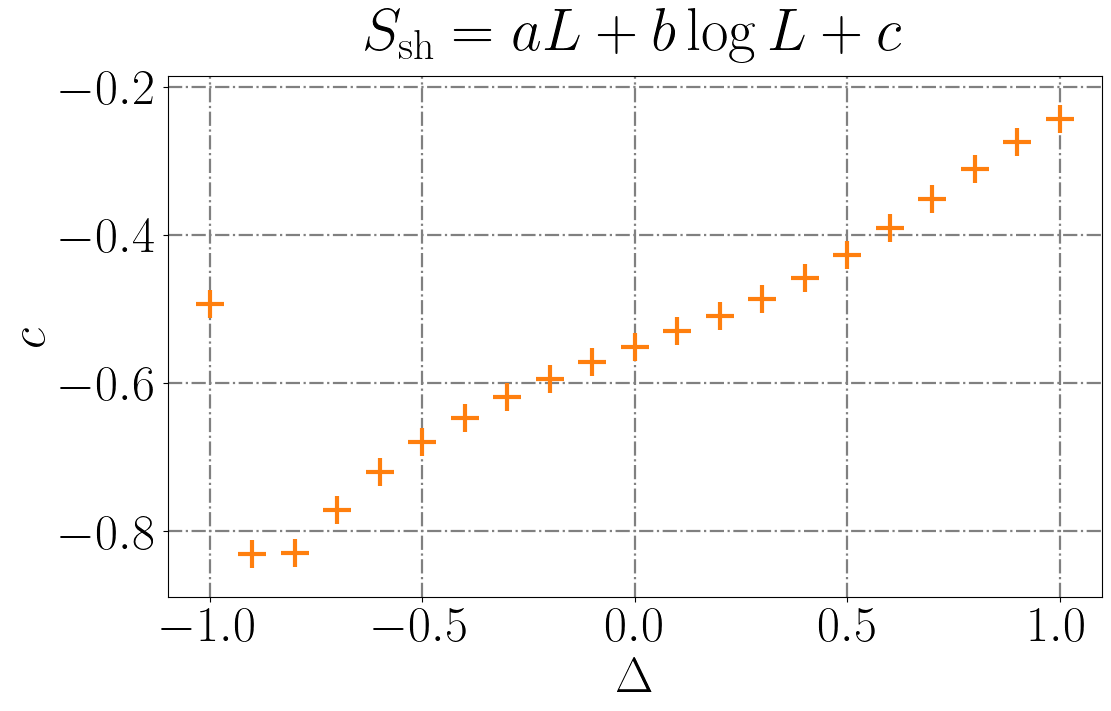

In [16]:
remove_last = 0

sl = slice(None, -remove_last if remove_last > 0 else None, None)
fig, ax = plt.subplots(1, 1, figsize=[12, 8])
yplot = [popt[2] for popt in params_arr[sl]]
plt.plot(delta_arr[sl], [popt[2] for popt in params_arr[sl]], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$c$")
plt.xlim(-0.05*(delta_range[1] - delta_range[0]) + delta_range[0], delta_range[1] + 0.05*(delta_range[1] - delta_range[0]))
plt.ylim(np.min(yplot) - 0.10*(np.max(yplot) - np.min(yplot)), np.max(yplot) + 0.10*(np.max(yplot) - np.min(yplot)))
plt.title(r"$S_{\mathrm{sh}} = a L + b \log L + c$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
# plt.savefig(f"gamma_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

##### 1.3.2 Negative global sign ($s = 1$)

1.3.2.1 Fit on the max amplitude
- Single $\Delta$ value

Num: N = 21 / Δ = 0.00
∞-Rènyi entropy fit result

Fit function: a L + b log L + c
a = 0.3462528315702527 ± 3.499755185761406e-05
b = 0.256883213496269 ± 0.0004983947626606453
c = -0.20897569164614832 ± 0.0008123409979914215


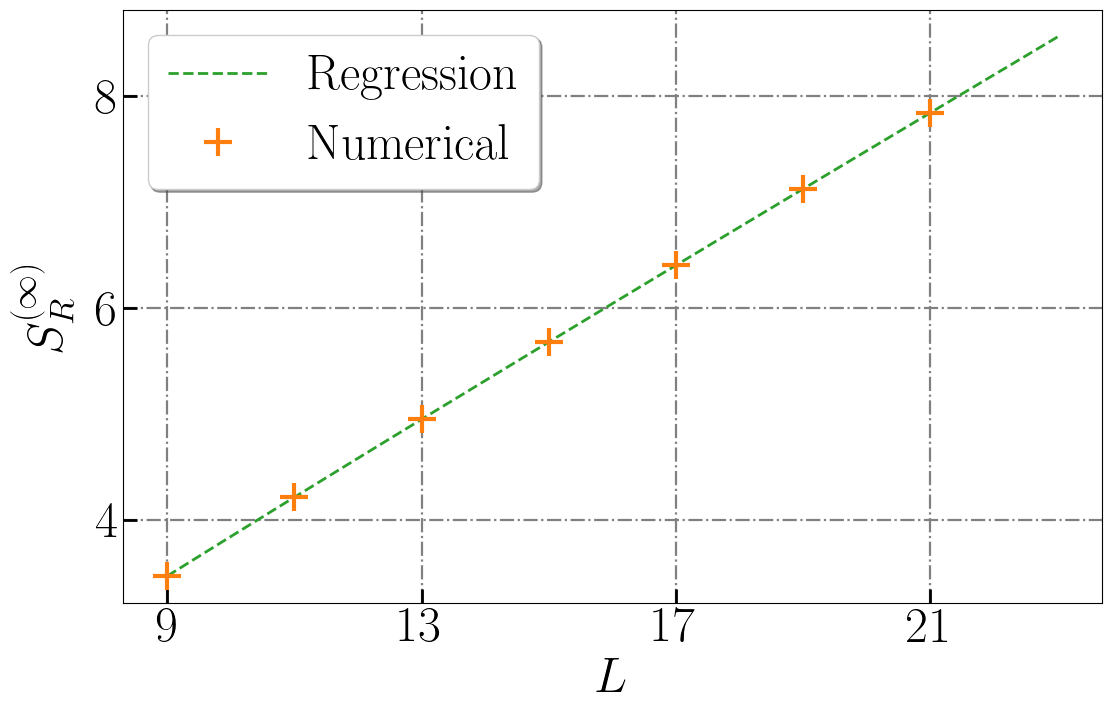

In [17]:
N_odd_range = [9, 23]
global_neg = True
delta = 0
print_mode = True
initials = [0.1, 0.1, 0.1]

N_arr = np.arange(*N_odd_range, 2)
max_amps_num_arr = amptools.get_xxz_numerical_max_amps(N_arr, delta, global_neg, print_mode=print_mode)

regression = curve_fit(to_fit_renyi_inf, N_arr, -np.log(max_amps_num_arr), p0=initials)
popt = regression[0]
errors = np.sqrt(np.diag(regression[1]))

print("\n∞-Rènyi entropy fit result\n")
print("Fit function: a L + b log L + c")
print(f"a = {popt[0]} ± {errors[0]}")
print(f"b = {popt[1]} ± {errors[1]}")
print(f"c = {popt[2]} ± {errors[2]}")

fig, ax = plt.subplots(1, 1, figsize=[12, 8])

smooth_N_arr = np.linspace(N_odd_range[0], N_odd_range[1], 1000)

plt.plot(smooth_N_arr, to_fit_renyi_inf(smooth_N_arr, *popt), "--", color="tab:green", linewidth=2, label="Regression")
plt.plot(N_arr, -np.log(max_amps_num_arr), "+", color="tab:orange", markersize=20, markeredgewidth=3, label="Numerical")

plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tick_params(width=2, length=10, direction="in")
plt.xlabel("$L$")
plt.ylabel(r"$S_{R}^{(\infty)}$", labelpad=15)
plt.xticks(np.arange(N_arr[0], N_arr[-1] + 1, 4))
plt.legend(shadow=True)
plt.tight_layout()

- Multiple $\Delta$ values

In [33]:
N_odd_range = [9, 21]
global_neg = True
delta_arr = np.linspace(-1, 1, 21)
print_mode = True
initials = [0.1, 0.1, 0.1]

N_arr = np.arange(*N_odd_range, 2)
params_arr = []
params_err_arr = []
max_amps_arr = amptools.get_xxz_numerical_max_amps(N_arr, delta_arr, global_neg, print_mode=print_mode)
for i, delta in enumerate(delta_arr):
    regression = curve_fit(to_fit_renyi_inf, N_arr, -np.log(max_amps_arr[:, i]), p0=initials)
    popt = regression[0]
    errors = np.sqrt(np.diag(regression[1]))
    params_arr.append(popt)
    params_err_arr.append(errors)

Num: N = 19 / Δ = 1.000

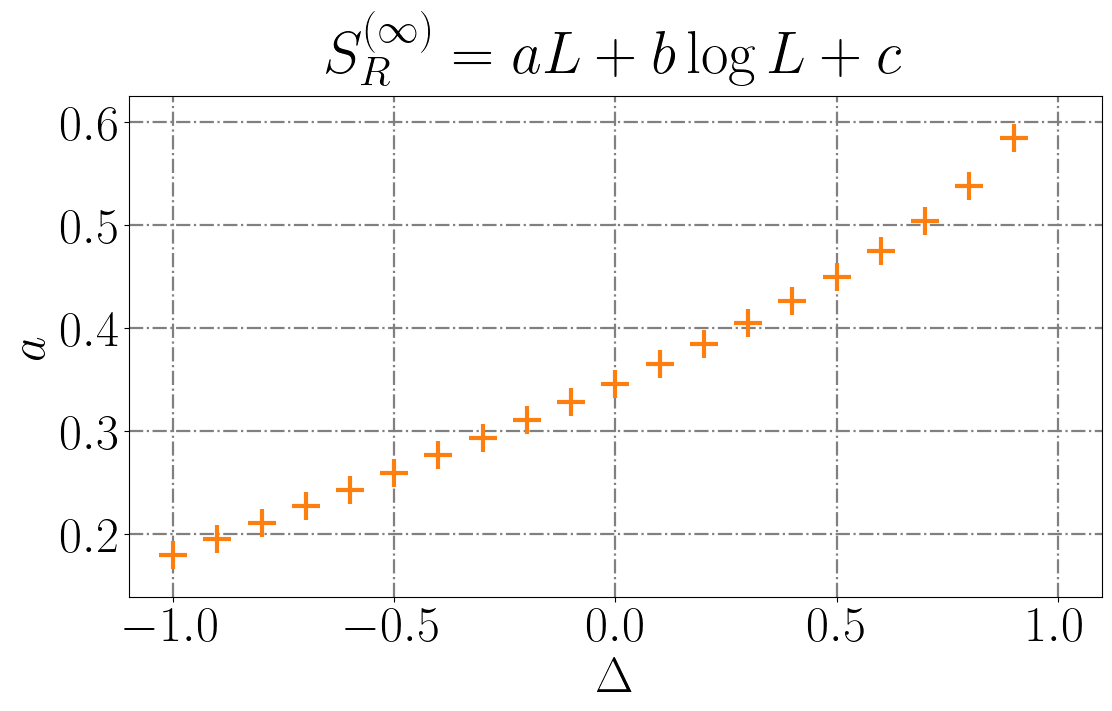

In [34]:
fig, ax = plt.subplots(1, 1, figsize=[12, 8])
yplot = np.array([popt[0] for popt in params_arr[:-1]])
plt.plot(delta_arr[:-1], yplot, "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$a$")
plt.xticks(np.linspace(*delta_range, 5))
plt.xlim(-0.05*(delta_range[1] - delta_range[0]) + delta_range[0], delta_range[1] + 0.05*(delta_range[1] - delta_range[0]))
plt.ylim(np.min(yplot) - 0.10*(np.max(yplot) - np.min(yplot)), np.max(yplot) + 0.10*(np.max(yplot) - np.min(yplot)))
plt.title(r"$S_{R}^{(\infty)} = a L + b \log L + c$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
# plt.savefig(f"alpha_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

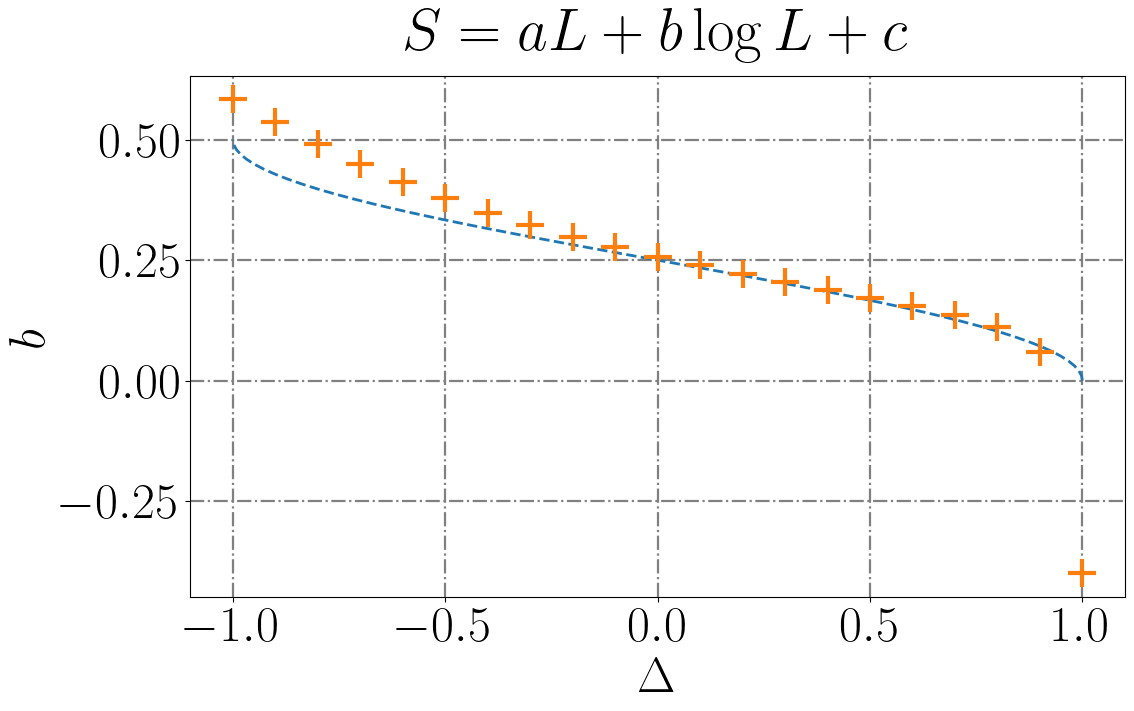

In [36]:
fig, ax = plt.subplots(1, 1, figsize=[12, 8])
beta = np.linspace(0, 0.5)
delta = np.cos(2*np.pi*beta)
plt.plot(delta[:], beta[:], "--", linewidth=2, label=r"$\Delta = -\cos(2\pi \alpha)$")
plt.plot(delta_arr[:], [popt[1] for popt in params_arr[:]], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$b$")
plt.title(r"$S = a L + b \log L + c$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
# plt.savefig(f"beta_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

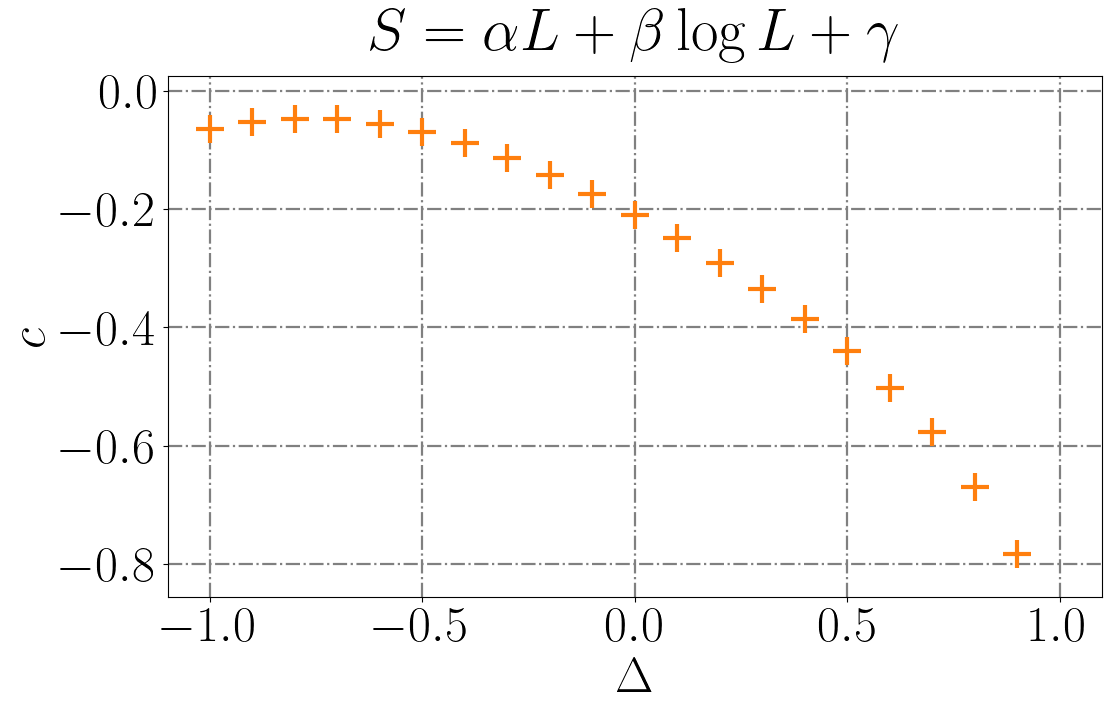

In [37]:
fig, ax = plt.subplots(1, 1, figsize=[12, 8])
yplot = [popt[2] for popt in params_arr[:-1]]
plt.plot(delta_arr[:-1], [popt[2] for popt in params_arr[:-1]], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$c$")
plt.xlim(-0.05*(delta_range[1] - delta_range[0]) + delta_range[0], delta_range[1] + 0.05*(delta_range[1] - delta_range[0]))
plt.ylim(np.min(yplot) - 0.10*(np.max(yplot) - np.min(yplot)), np.max(yplot) + 0.10*(np.max(yplot) - np.min(yplot)))
plt.title(r"$S = \alpha L + \beta \log L + \gamma$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
# plt.savefig(f"gamma_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

Values at special points:

In [38]:
delta_special_points = [-1, -0.5, 0, 0.5, 1]

for sdelta in delta_special_points:
    ind = np.argmin(np.abs(delta_arr - sdelta))
    print(f"Δ = {sdelta:.02f} | a = {params_arr[ind][0]} | b = {params_arr[ind][1]} | c = {params_arr[ind][2]}")

Δ = -1.00 | a = 0.17941954920915398 | b = 0.583970416851709 | c = -0.06535852879327965
Δ = -0.50 | a = 0.2599106175476834 | b = 0.37854994489913674 | c = -0.06969133370418602
Δ = 0.00 | a = 0.34620298895668355 | b = 0.2575087495915402 | c = -0.2099149060960365
Δ = 0.50 | a = 0.4497070277683979 | b = 0.1722882691654202 | c = -0.4403391924573997
Δ = 1.00 | a = 0.6896020041189176 | b = -0.4000555353438868 | c = -0.49099972673719167


1.3.2.1 Fit on the Shannon entropy
- Single $\Delta$ value

Num: N = 19
Shannon entropy fit result

Fit function: a L + b log L + c
a = 0.49431947073855736 ± 0.00015149969671332178
b = 0.020058619691908256 ± 0.0020331869588141737
c = -0.39146071216350603 ± 0.0032020993300630454


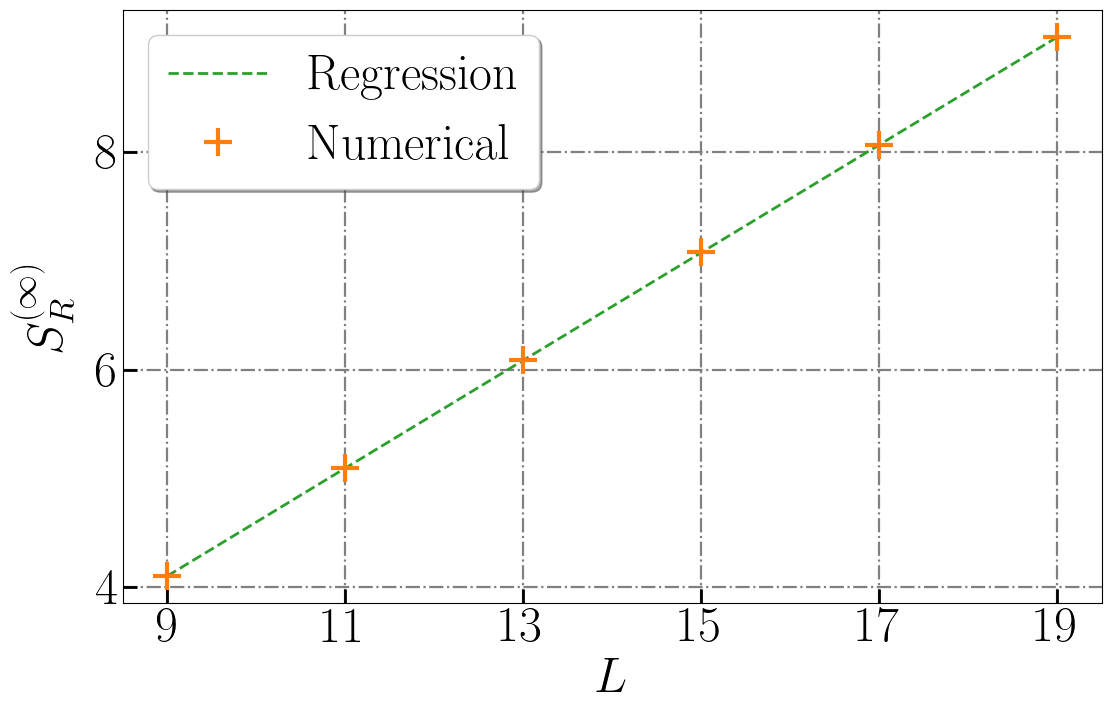

In [39]:
N_odd_range = [9, 21]
global_neg = True
delta = -1/2
print_mode = True
initials = [0.1, 0.1, 0.1]

N_arr = np.arange(*N_odd_range, 2)
shannon_arr = amptools.get_xxz_numerical_shannon(N_arr, delta, global_neg, print_mode=print_mode)

regression = curve_fit(to_fit_shannon, N_arr, shannon_arr, p0=initials)
popt = regression[0]
errors = np.sqrt(np.diag(regression[1]))

print("\nShannon entropy fit result\n")
print("Fit function: a L + b log L + c")
print(f"a = {popt[0]} ± {errors[0]}")
print(f"b = {popt[1]} ± {errors[1]}")
print(f"c = {popt[2]} ± {errors[2]}")

fig, ax = plt.subplots(1, 1, figsize=[12, 8])

smooth_N_arr = np.linspace(N_odd_range[0], N_odd_range[1] - 2, 1000)

plt.plot(smooth_N_arr, to_fit_shannon(smooth_N_arr, *popt), "--", color="tab:green", linewidth=2, label="Regression")
plt.plot(N_arr, shannon_arr, "+", color="tab:orange", markersize=20, markeredgewidth=3, label="Numerical")

plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tick_params(width=2, length=10, direction="in")
plt.xlabel("$L$")
plt.ylabel(r"$S_{R}^{(\infty)}$", labelpad=15)
plt.xticks(np.arange(N_arr[0], N_arr[-1]+2, 2))
plt.legend(shadow=True)
plt.tight_layout()

- Multiple $\Delta$ values

In [40]:
N_odd_range = [9, 21]
global_neg = False
delta_arr = np.linspace(-1, 1, 21)
print_mode = True
initials = [0.1, 0.1, 0.1]

N_arr = np.arange(*N_odd_range, 2)
params_arr = []
params_err_arr = []
shannon_arr = amptools.get_xxz_numerical_shannon(N_arr, delta_arr, global_neg, print_mode=print_mode)
for i, delta in enumerate(delta_arr):
    regression = curve_fit(to_fit_shannon, N_arr, shannon_arr[:, i], p0=initials)
    popt = regression[0]
    errors = np.sqrt(np.diag(regression[1]))
    params_arr.append(popt)
    params_err_arr.append(errors)

Num: N = 17

Num: N = 19

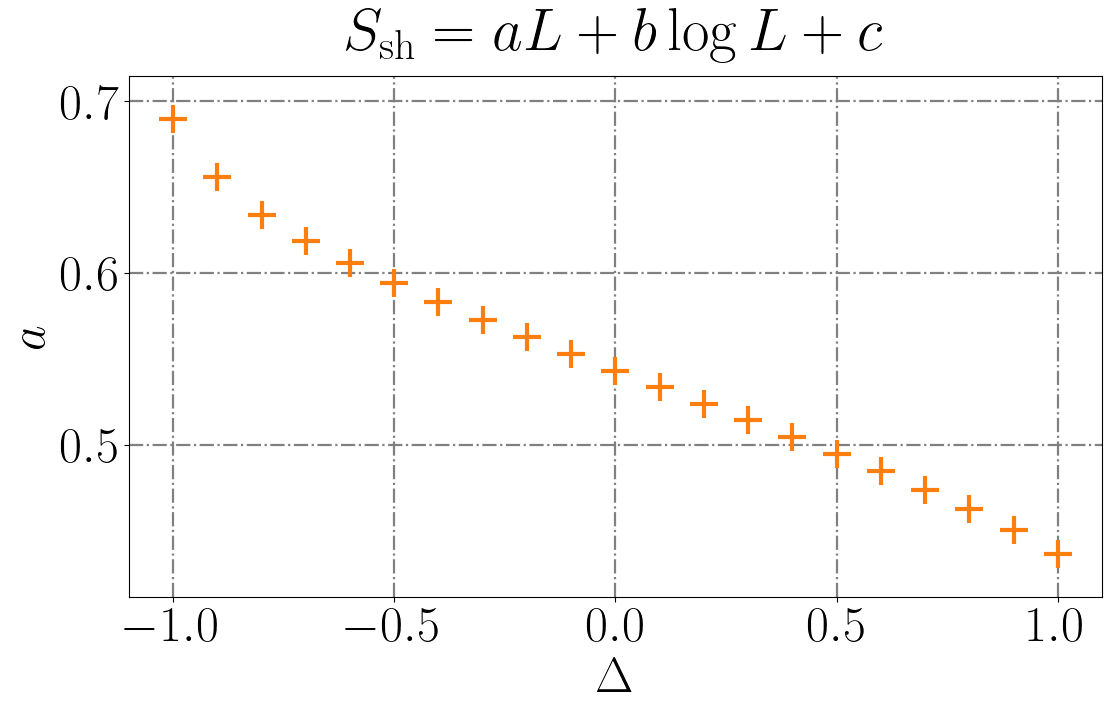

In [41]:
remove_last = 0

sl = slice(None, -remove_last if remove_last > 0 else None, None)
fig, ax = plt.subplots(1, 1, figsize=[12, 8])
yplot = np.array([popt[0] for popt in params_arr[sl]])
plt.plot(delta_arr[sl], yplot[sl], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$a$")
plt.xticks(np.linspace(*delta_range, 5))
plt.xlim(-0.05*(delta_range[1] - delta_range[0]) + delta_range[0], delta_range[1] + 0.05*(delta_range[1] - delta_range[0]))
plt.ylim(np.min(yplot) - 0.10*(np.max(yplot) - np.min(yplot)), np.max(yplot) + 0.10*(np.max(yplot) - np.min(yplot)))
plt.title(r"$S_{\mathrm{sh}} = a L + b \log L + c$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
# plt.savefig(f"alpha_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

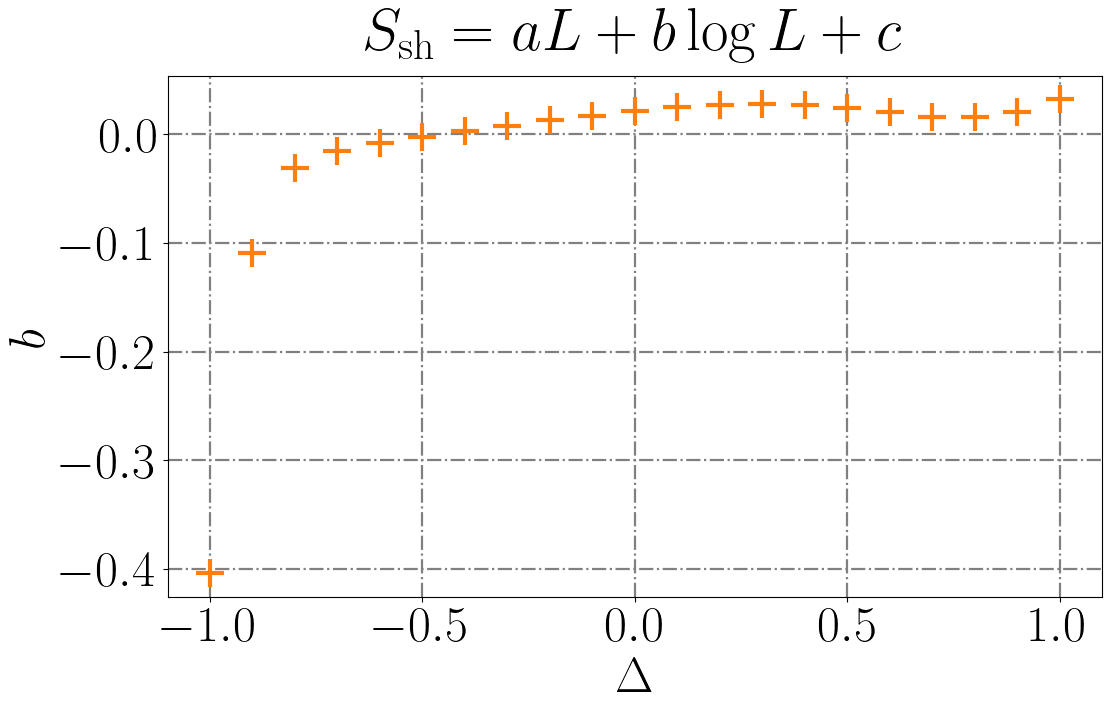

In [42]:
remove_last = 0

sl = slice(None, -remove_last if remove_last > 0 else None, None)
fig, ax = plt.subplots(1, 1, figsize=[12, 8])
plt.plot(delta_arr[sl], [popt[1] for popt in params_arr[sl]], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$b$")
plt.title(r"$S_{\mathrm{sh}} = a L + b \log L + c$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
# plt.savefig(f"beta_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

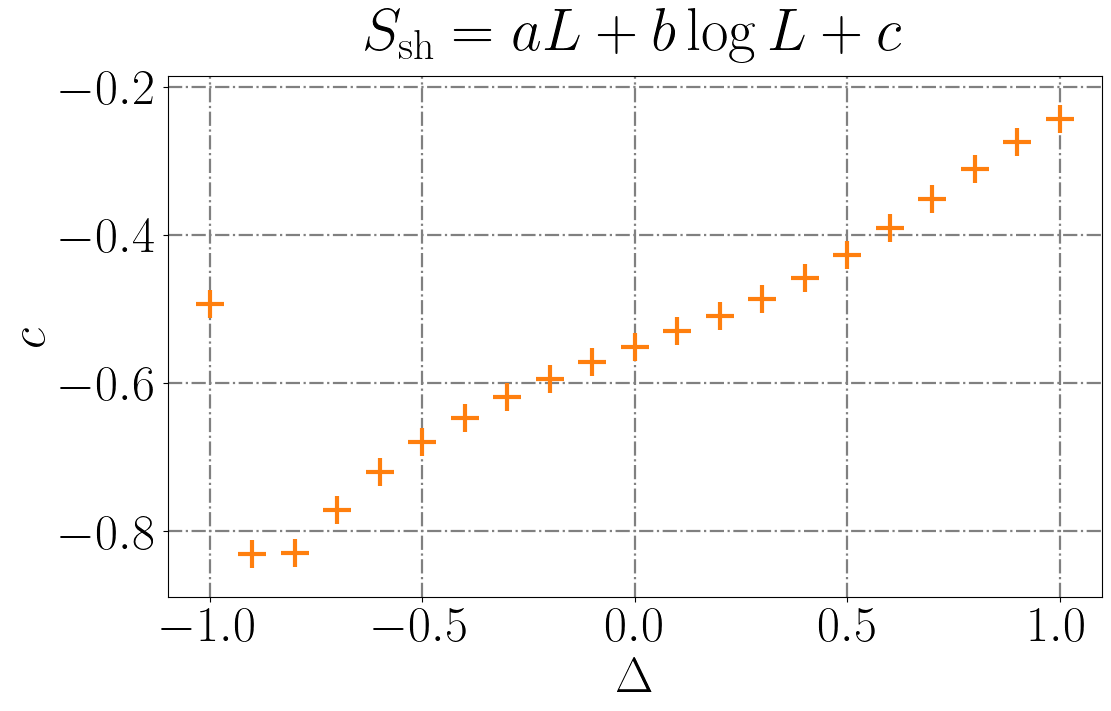

In [43]:
remove_last = 0

sl = slice(None, -remove_last if remove_last > 0 else None, None)
fig, ax = plt.subplots(1, 1, figsize=[12, 8])
yplot = [popt[2] for popt in params_arr[sl]]
plt.plot(delta_arr[sl], [popt[2] for popt in params_arr[sl]], "+", color="tab:orange", markersize=20, markeredgewidth=3)
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$c$")
plt.xlim(-0.05*(delta_range[1] - delta_range[0]) + delta_range[0], delta_range[1] + 0.05*(delta_range[1] - delta_range[0]))
plt.ylim(np.min(yplot) - 0.10*(np.max(yplot) - np.min(yplot)), np.max(yplot) + 0.10*(np.max(yplot) - np.min(yplot)))
plt.title(r"$S_{\mathrm{sh}} = a L + b \log L + c$", pad=18)
plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
plt.tight_layout()
# plt.savefig(f"gamma_scaling_with_delta_{delta_arr[0]:.04f}_{delta_arr[-1]:.04f}_N_{N_odd_range[0]}_{N_odd_range[-1]}.png", dpi=300)

In [44]:
delta_special_points = [-1, -0.5, 0, 0.5, 1]

for sdelta in delta_special_points:
    ind = np.argmin(np.abs(delta_arr - sdelta))
    print(f"Δ = {sdelta:.02f} | a = {params_arr[ind][0]} | b = {params_arr[ind][1]} | c = {params_arr[ind][2]}")

Δ = -1.00 | a = 0.6897719844906329 | b = -0.4039333595059242 | c = -0.49356679593931846
Δ = -0.50 | a = 0.5943758771102925 | b = -0.002456885796498991 | c = -0.6801322307397735
Δ = 0.00 | a = 0.5432088539013042 | b = 0.021383795231381134 | c = -0.5507652071754585
Δ = 0.50 | a = 0.49474215779022 | b = 0.02409867943028803 | c = -0.4271509924391356
Δ = 1.00 | a = 0.4366441058030522 | b = 0.03228324779669351 | c = -0.24374580376183333
